In [1]:
import numpy as np
import torch



In [2]:
x = torch.ones(2,2)
print(x)

tensor([[1., 1.],
        [1., 1.]])


In [3]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

In [4]:
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))


trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim =1)
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [7]:
for epoch in range(3): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,784))  # pass in the reshaped batch (recall they are 28x28 atm)
        loss = F.nll_loss(output, y)  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

tensor(0.1604, grad_fn=<NllLossBackward>)
tensor(0.2060, grad_fn=<NllLossBackward>)
tensor(0.0007, grad_fn=<NllLossBackward>)


In [8]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.972


In [9]:
import matplotlib.pyplot as plt

plt.imshow(X[0].view(28,28))
plt.show()

<Figure size 640x480 with 1 Axes>

In [10]:
a_featureset = X[0]
reshaped_for_network = a_featureset.view(-1,784) # 784 b/c 28*28 image resolution.
output = net(reshaped_for_network) #output will be a list of network predictions.
first_pred = output[0]
print(first_pred)

tensor([-2.2766e+01, -1.7961e+01, -1.4540e+01, -1.5774e+01, -2.4069e+01,
        -2.1274e+01, -4.1184e+01, -1.3113e-06, -2.0611e+01, -1.4261e+01],
       grad_fn=<SelectBackward>)


In [11]:
biggest_index = torch.argmax(first_pred)
print(biggest_index)

tensor(7)


In [13]:
import os
import cv2
from tqdm import tqdm

REBUILD_DATA = True

In [14]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|████████████████████████████████████████████████████████████████████████████| 12501/12501 [05:01<00:00, 41.42it/s]


PetImages/Dog


100%|████████████████████████████████████████████████████████████████████████████| 12501/12501 [04:35<00:00, 45.42it/s]


Cats: 12476
Dogs: 12470


In [15]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [45]:
import torch
net = Net().to()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

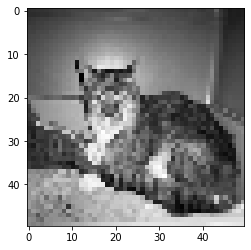

In [59]:
import matplotlib.pyplot as plt

plt.imshow(X[4], cmap="gray")

In [18]:
print(y[0])

tensor([0., 1.])


In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

In [20]:
 def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [46]:
import torch.optim as optim
net = Net().to()

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [23]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [24]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [25]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

22452 2494


In [27]:

BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:51<00:00,  1.27it/s]


Epoch: 0. Loss: 0.17425622045993805


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:48<00:00,  1.03s/it]


Epoch: 1. Loss: 0.15940028429031372


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:42<00:00,  1.19it/s]


Epoch: 2. Loss: 0.12670539319515228


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [04:09<00:00,  1.01s/it]


Epoch: 3. Loss: 0.11114479601383209


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [04:25<00:00,  1.04s/it]


Epoch: 4. Loss: 0.10114619135856628


In [41]:

from tqdm import tqdm

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        
        matches = [torch.argmax(i)==torch.argmax(j) for i,j in zip (outputs, batch_y)]
        in_sample_acc = matches.count(True)/len(matches)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update
    
    print(loss)
    print("In-sample acc:", round(in_sample_acc,2))
train(net)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:32<00:00,  1.68it/s]


tensor(0.0482, grad_fn=<MseLossBackward>)
In-sample acc: 0.96


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:32<00:00,  1.74it/s]


tensor(0.0384, grad_fn=<MseLossBackward>)
In-sample acc: 0.96


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:32<00:00,  1.77it/s]


tensor(0.0434, grad_fn=<MseLossBackward>)
In-sample acc: 0.96


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:33<00:00,  1.61it/s]


tensor(0.0386, grad_fn=<MseLossBackward>)
In-sample acc: 0.96


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:36<00:00,  1.70it/s]


tensor(0.0369, grad_fn=<MseLossBackward>)
In-sample acc: 0.96


In [39]:
def batch_test(net):
    BATCH_SIZE-100
    correct = 0
    total = 0
with torch.no_grad():
        batch_X = test_X[:BATCH_SIZE].view(-1, 1, 50, 50)
        batch_Y = test_y[:BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        
        matches = [torch.argmax(i)==torch.argmax(j) for i,j in zip (outputs, batch_y)]
        in_sample_acc = matches.count(True)/len(matches)
        
print("Accuracy: ", round(in_sample_acc, 3))
batch_test(net)

Accuracy:  0.558


In [56]:
print("Model's state dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
print ("Optimizer's state dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
torch.save(net.state_dict(), 'MyNet.pt')

Model's state dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 512])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])
Optimizer's state dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [2317757450064, 2317953022280, 2317953023432, 2317844096272, 2317844096200, 2317844095048, 2317844095408, 2317844098936, 2317844097496, 2317844095264]}]


# NO. 1 dan 2

1.-zero_grad()  # sets gradients ke 0 sebelum kehilangan kalkulasi. Dilakukan untuk setiap step
-no grad( ) #Ini dapat sangat membantu ketika mengevaluasi suatu model karena model tersebut mungkin memiliki parameter yang dapat dilatih dengan require_grad = True
2.torch.flatten() digunakan untuk meratakan kisaran dims(gambar remang-remang) yang berdekatan dalam tensor.
    